In [ ]:
import matplotlib.pyplot as plt
import scipy.fftpack
import cv2
import math
import numpy as np
from numpy import *
import scipy.stats as s
from scipy import signal
from scipy import misc # pip install Pillow
import matplotlib.pylab as pyla

In [ ]:
# <------------------------ Helpers ---------------------------->

In [ ]:
def compute_psnr(img1, img2):
    #img1 = img1.astype(np.float64) / 255.
    #img2 = img2.astype(np.float64) / 255.
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_pixel=255.0
    a= 20 * np.log10(max_pixel/np.sqrt(mse))
    return a
    

In [ ]:
# <------------------------- Attacks --------------------------->

In [ ]:
def meanFilter(im):
    img = im
    w = 2

    for i in range(2,im.shape[0]-2):
        for j in range(2,im.shape[1]-2):
            block = im[i-w:i+w+1, j-w:j+w+1]
            m = np.mean(block,dtype=np.float32)
            img[i][j] = int(m)
    return img

def addNoise(img):                                  
    column, row = img.shape
    mean = 0
    var = 1
    sigma = var ** 0.5
    guass = np.random.normal(mean, sigma, (row, column))
    guass = guass.reshape(column, row)
    noisy = img + guass
    return noisy

def distorition(im_path):
    img=im_path
    color_img = img
    
    A = img.shape[0] / 3.0
    w = 2.0 / img.shape[1]
    shift = lambda x: A * np.sin(1 * np.pi * x * w)
    for i in range(img.shape[0]):
        img[:, i] = np.roll(img[:, i], int(shift(i)))
    return img
    
def brighter10(img: np.ndarray):
        img = img.copy()
        w, h = img.shape[:2]
        for xi in range(0, w):
            for xj in range(0, h):
                img[xi, xj] = int(img[xi, xj] * 1.1)
                img[xi, xj] = int(img[xi, xj] * 1.1)
               
        return img
        
def rotate(img: np.ndarray,angle):
    (h, w) = img.shape[:2]
    # calculate the center of the image
    center = (w / 2, h / 2)
    scale = 1.0

    # Perform the counter clockwise rotation holding at the center
    # 90 degrees
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated90 = cv2.warpAffine(img, M, (h, w))
    return rotated90

In [ ]:
# <-------------------- DCT and inverse DCT ------------------------->

In [ ]:
def dct2(a):
    return scipy.fftpack.dct( scipy.fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

def idct2(a):
    return scipy.fftpack.idct( scipy.fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

def apply_dct(image_array):
    
    size = image_array[0].__len__()
    all_subdct = np.empty((size, size))
    
    for i in range (0, size, 16):
        for j in range (0, size, 16):
            
            subpixels = image_array[i:i+16, j:j+16]
            subdct = scipy.fftpack.dct(scipy.fftpack.dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+16, j:j+16] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    
    size = all_subdct[0].__len__()
    all_subidct = np.empty((size, size))
    
    for i in range (0, size, 16):
        for j in range (0, size, 16):
            subidct = scipy.fftpack.idct(scipy.fftpack.idct(all_subdct[i:i+16, j:j+16].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+16, j:j+16] = subidct

    return all_subidct

In [ ]:
# <--------------------Algorithm------------------------->

In [ ]:
def embed(dct, watermarkImage):
    sig=8
    water_mark=watermarkImage.ravel()
    flag=0
    for i in range (0, 512, 16):
        for j in range (0, 512, 16):
          if(flag<len(water_mark)):
            dct[i+11][j+11]=water_mark[flag]
            flag=flag+1
        if(flag>=len(water_mark)):
          break


    return dct            

In [ ]:
# <---------------- Watermark extraction ---------------------->

In [ ]:
def extract_watermark(im_dct):
    extract_water_mark=[]
    sig=0
    i_dct=apply_dct(im_dct)
    for i in range (0, 512, 16):
        for j in range (0, 512, 16):
          if(sig<(32*32)):
            extract_water_mark.append(i_dct[i+11][j+11])
          sig=sig+1
        if(sig>=(32*32)):
          break

      
    extract_water_mark=np.array(extract_water_mark).reshape(32,32)
    return extract_water_mark

# Working

(32, 32)
[[  9  30  38 ...  36  38  41]
 [ 30 134 184 ... 183 143  62]
 [ 38 184 255 ... 255 194  70]
 ...
 [ 38 184 255 ... 255 194  70]
 [ 30 134 184 ... 183 143  62]
 [  9  30  38 ...  36  38  41]]


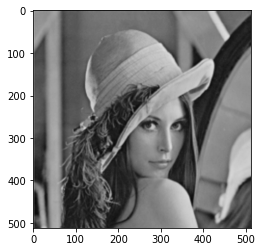

In [ ]:
# Read image
originalImage = cv2.cvtColor(cv2.imread("lena.png"),cv2.COLOR_BGR2GRAY)
originalImage.resize(512,512)
plt.imshow(originalImage,cmap='gray')
# Read watermark
watermarkImage = cv2.cvtColor(cv2.imread("/content/logo.png"), cv2.COLOR_BGR2GRAY)
watermarkImage = cv2.resize(watermarkImage, (32, 32))
#plt.imshow(watermarkImage,cmap='gray')

print(watermarkImage.shape)
# y=np.array(watermarkImage.shape)
print(watermarkImage)

In [ ]:
dct = apply_dct(originalImage)

In [ ]:
dct=embed(dct, watermarkImage)


In [ ]:
carrierImage = inverse_dct(dct)
print(carrierImage.shape)

(512, 512)


In [ ]:
print(compute_psnr(carrierImage, originalImage))


26.81997012680888


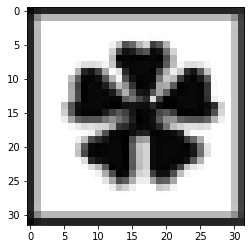

In [ ]:
plt.imshow(watermarkImage,cmap='gray')

In [ ]:
#extract watermark 
extracted_watermark = extract_watermark(carrierImage)
print(compute_psnr(watermarkImage, extracted_watermark))

51.75488573903599


NC value of the extracted logo = [[0.9999989]]


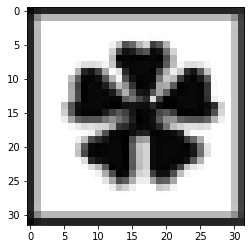

In [ ]:
plt.imshow(extracted_watermark,cmap='gray')
img1=watermarkImage
img2=extracted_watermark

nc_res = cv2.matchTemplate(img1.astype(np.uint8), img2.astype(np.uint8),cv2.TM_CCORR_NORMED)
print('NC value of the extracted logo = {}'.format(nc_res))

# ATTACKS


In [ ]:
#Rotate Image by 180
carrierImageRotated = rotate(carrierImage,180)
watermarkAfterRotation = extract_watermark(carrierImageRotated)
img1=watermarkImage
img2=watermarkAfterRotation

NC value of the attacked logo = [[0.9033982]]


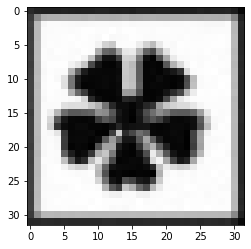

In [ ]:
# watermark After Rotation
plt.imshow(watermarkAfterRotation, cmap='gray')
img1=watermarkImage
img2=watermarkAfterRotation
nc_res = cv2.matchTemplate(img1.astype(np.uint8), img2.astype(np.uint8),cv2.TM_CCORR_NORMED)
print('NC value of the attacked logo = {}'.format(nc_res))


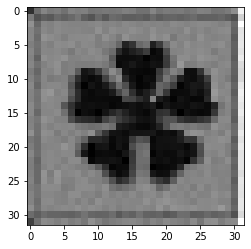

In [ ]:
# mean filter
attacked = meanFilter(np.copy(carrierImage))
#plt.imshow(attacked, cmap='gray')
plt.imshow(extract_watermark(attacked), cmap='gray')


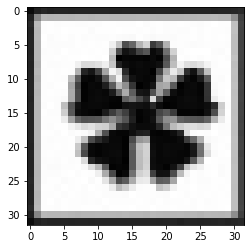

In [ ]:
# add noise
noiseAttacked = addNoise(carrierImage)
plt.imshow(extract_watermark(noiseAttacked), cmap='gray')

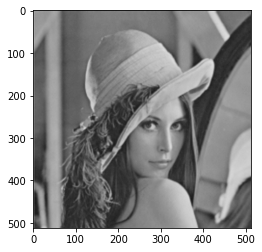

In [ ]:
noisyImage = addNoise(carrierImage)
plt.imshow(noisyImage,cmap='gray')

In [ ]:
#Brighter attack
brighted=brighter10(np.copy(carrierImage))

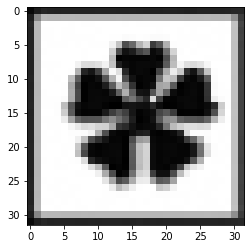

In [ ]:
plt.imshow(extract_watermark(brighted), cmap='gray')

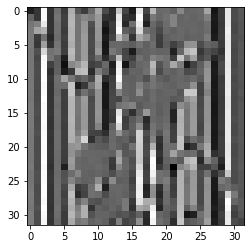

In [ ]:
#distortion attack
distorition_a=distorition(np.copy(carrierImage))
plt.imshow(extract_watermark(distorition_a), cmap='gray')